<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

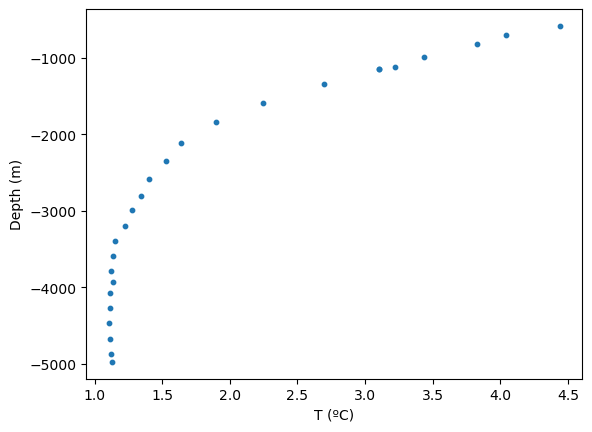

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation. 

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater. 

2024-12-19 09:54:50,443 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


Text(0, 0.5, 'Depth (m)')

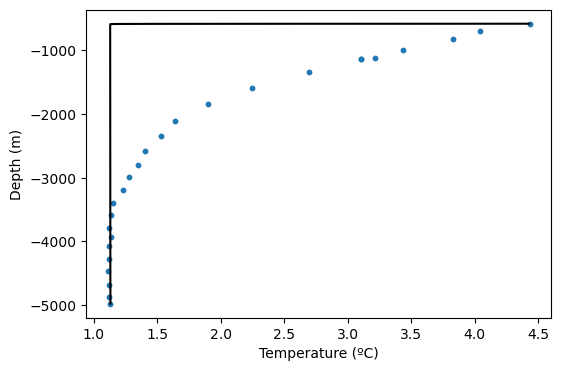

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
from scipy.interpolate import interp1d

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-7 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water. 

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data. 

2024-12-19 09:54:50,950 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+00/s
[1.12962971 1.12963032 1.12963153 1.12963336 1.1296358  1.12963885
 1.12964251 1.12964677 1.12965165 1.12965714 1.12966324 1.12966995
 1.12967728 1.12968521 1.12969376 1.12970293 1.1297127  1.12972309
 1.1297341  1.12974572 1.12975796 1.12977082 1.12978429 1.12979839
 1.1298131  1.12982843 1.12984439 1.12986097 1.12987817 1.129896
 1.12991446 1.12993354 1.12995325 1.12997359 1.12999456 1.13001616
 1.13003839 1.13006127 1.13008477 1.13010892 1.1301337  1.13015913
 1.1301852  1.13021191 1.13023927 1.13026727 1.13029593 1.13032524
 1.13035519 1.13038581 1.13041708 1.13044901 1.1304816  1.13051485
 1.13054877 1.13058336 1.13061861 1.13065454 1.13069114 1.13072841
 1.13076637 1.130805   1.13084432 1.13088433 1.13092502 1.1309664
 1.13100848 1.13105125 1.13109472 1.1311389  1.13118377 1.13122936
 1.13127565 1.13132266 1.13137039 1.13141883 1.13146799 1.13151788


Text(0, 0.5, 'Depth (m)')

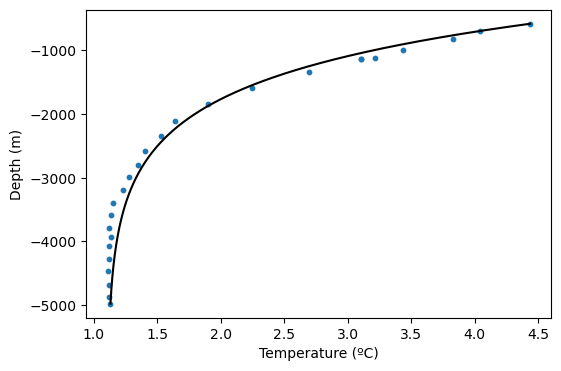

In [4]:
#TODO: could have a look at maybe running an optimisation to find a better value for kappa 

# Here we attempt to find a value of the diffusivity that gives a good match with the data:

"""
Dedalus script to solve the steady advection/diffusion equation
"""


# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=9e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']

print(Tg)
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')


#### 1.4.1 Kappa value discussion 

The value of diffusivity used in the odel above is $9 \times  10^{-5} m^2/s$ 

This value is approimately 1000 times greater than the initial value given in the practical. The new value of kappa fits the model decently well but still slightly overestimates the temperature of the deep ocean. 

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$. 

2024-12-19 09:54:51,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+00/s


Text(0, 0.5, 'Depth (m)')

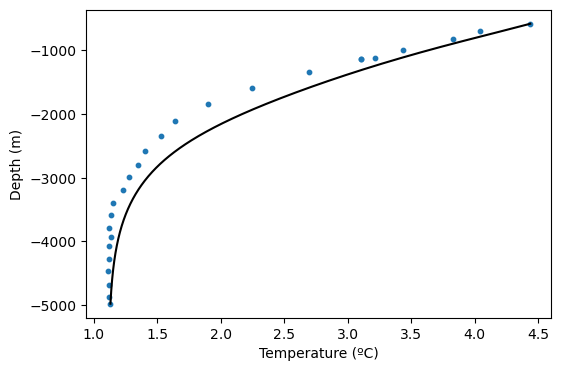

In [5]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 0 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

#### 1.6.0 Variable diffusivity investigation 



In this investigation we are going to:

1. Find a vertical velocity that produces a better agreement with the observations 
2. Look at varying the profile of $\kappa(z)$ 
3. Then we are going to look at the sensitivity of $\kappa(z)$ to small perturbations in w
4. Discuss what implications this has on the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography 

#### 1.6.1 Variable vertical velocity 

In [6]:
# To aid in assessing what values in this practical give the best fit - we are going to write a function that returns both the R^2 and mean squared error values between the dedalus model 
# and measure temperature profile 

def calculate_mse_r2(Tg, z, CTD_T, CTD_z):
    """
    Calculate the mean squared error and R² value between the simulated temperature profile and the observed data.
    
    Parameters:
    - Tg: Array of simulated temperature values from Dedalus.
    - z: Array of corresponding depths for the simulated temperature values.
    - CTD_T: Array of observed temperatures from the CTD data.
    - CTD_z: Array of corresponding depths for the observed temperatures.
    
    Returns:
    - mse: Mean squared error between the simulated and observed temperatures.
    - r2: Coefficient of determination (R²) value.
    """
    # Interpolate the simulated temperature profile to the depths of the CTD data
    interp_func = interp1d(z, Tg, kind='linear', fill_value="extrapolate")
    Tg_interpolated = interp_func(CTD_z)
    
    # Calculate the mean squared error
    mse = np.mean((Tg_interpolated - CTD_T) ** 2)
    
    # Calculate the R² value
    ss_res = np.sum((CTD_T - Tg_interpolated) ** 2)
    ss_tot = np.sum((CTD_T - np.mean(CTD_T)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return mse, r2

2024-12-19 09:54:51,960 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s
2024-12-19 09:54:52,180 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s
2024-12-19 09:54:52,398 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s
2024-12-19 09:54:52,615 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s
2024-12-19 09:54:52,839 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s
2024-12-19 09:54:53,070 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s
2024-12-19 09:54:53,338 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s
2024-12-19 09:54:53,564 subsystems 0/1 INFO :: Building subproblem matrices 

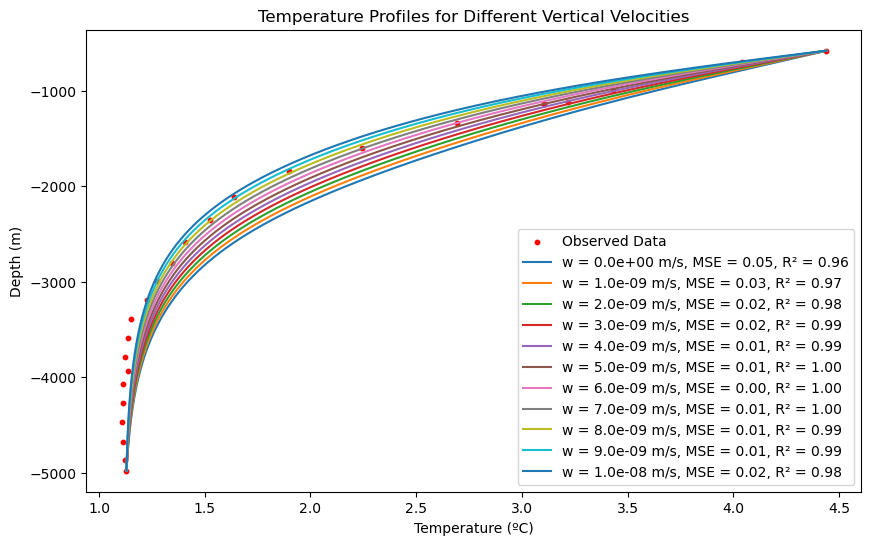

[0.e+00 1.e-09 2.e-09 3.e-09 4.e-09 5.e-09 6.e-09 7.e-09 8.e-09 9.e-09
 1.e-08]
[np.float64(0.04798936951905228), np.float64(0.03472890798564181), np.float64(0.02385836045088173), np.float64(0.015388292064803319), np.float64(0.00931004113529003), np.float64(0.005596094067758064), np.float64(0.004200835777281968), np.float64(0.0050616438834269984), np.float64(0.0081002835740095), np.float64(0.013224551133540098), np.float64(0.02033010813225359)]
[np.float64(0.9582799201637369), np.float64(0.9698080464838783), np.float64(0.9792584751008667), np.float64(0.9866220210867233), np.float64(0.9919062145776057), np.float64(0.9951349748159243), np.float64(0.9963479577714048), np.float64(0.9955996048909234), np.float64(0.9929579304585388), np.float64(0.9885030927761825), np.float64(0.982325799591496)]


In [7]:
w_values = np.linspace(0, 1e-8, 11)
r_values = []
ms_values = []

plt.figure(figsize=(10, 6))
plt.scatter(CTD_T, CTD_z, s=10, color='red', label="Observed Data")
for w in w_values:
    # Dedalus code setup and solver
    z_surface = CTD_z[-1]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[-1]
    T_bottom = CTD_T[0]
    Nz = 1000
    
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)
    
    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    kappa['g'] = 1e-5 + (8.6e-4 - 1e-5) * np.exp((-5e3 - z) / 667)
    
    # Tau variables and problem setup
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)
    
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")
    
    # Solver
    solver = problem.build_solver()
    solver.solve()
    
    # Retrieve the model results
    Tg = T['g']
    
    # Calculate MSE and R²
    mse, r2 = calculate_mse_r2(Tg, z, CTD_T, CTD_z)
    
    r_values.append(r2)
    ms_values.append(mse)
    
    # Plot
    plt.plot(Tg, z, label=f"w = {w:.1e} m/s, MSE = {mse:.2f}, R² = {r2:.2f}")

# Plot the observed data for reference

plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

plt.legend()
plt.title("Temperature Profiles for Different Vertical Velocities")
plt.show()

print(w_values)
print(ms_values)
print(r_values)

A very small vertical velocity can be used in order to better fit the temperature profile of the ocean.

Some examples of the velocities used and the mean squared errors associated with the velocities used are given below

| Vertical velocity | Mean Squared error | $R^2$ value |
| --- | --- | --- |
| 0.00 | 0.05 | 0.96 |
| 1.00 | 0.03 | 0.97 |
| 2.00 | 0.02 | 0.98 |
| 3.00 | 0.02 | 0.99 |
| 4.00 | 0.01 | 0.99 |
| 5.00 | 0.01 | 1.00 |
| 6.00 | 0.00 | 1.00 |
| 7.00 | 0.01 | 1.00 |
| 8.00 | 0.01 | 0.99 |
| 9.00 | 0.01 | 0.99 |
| 10.00 | 0.02 | 0.98 |


#### 1.6.2 Variable kappa profile

Our function for kappa is defined as:



$$\kappa = a + (b - c) * \exp\bigg(\frac{d - z}{f}\bigg)$$



The initial values used in previous investigations were:

| Parameter | Value |
| --- | --- |
| a | 1e-5 |
| b | 8.6e-4 |
| c | 1e-5 |
| d | -5e3|
| f | 667 |

We are going to look at how varying of parameters a, b and d affects how well the dedalus model fits the observed temperature profile of the ocean. For this investigation, we pick the optimal $w$ to be $6\times10^{-9} ms^{-1}$, obtained from the investigaton above.

2024-12-19 10:01:21,828 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s
2024-12-19 10:01:22,138 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s
2024-12-19 10:01:22,391 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s
2024-12-19 10:01:22,800 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2024-12-19 10:01:23,044 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s
2024-12-19 10:01:23,343 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2024-12-19 10:01:23,613 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s
2024-12-19 10:01:23,840 subsystems 0/1 INFO :: Building subproblem matrices 

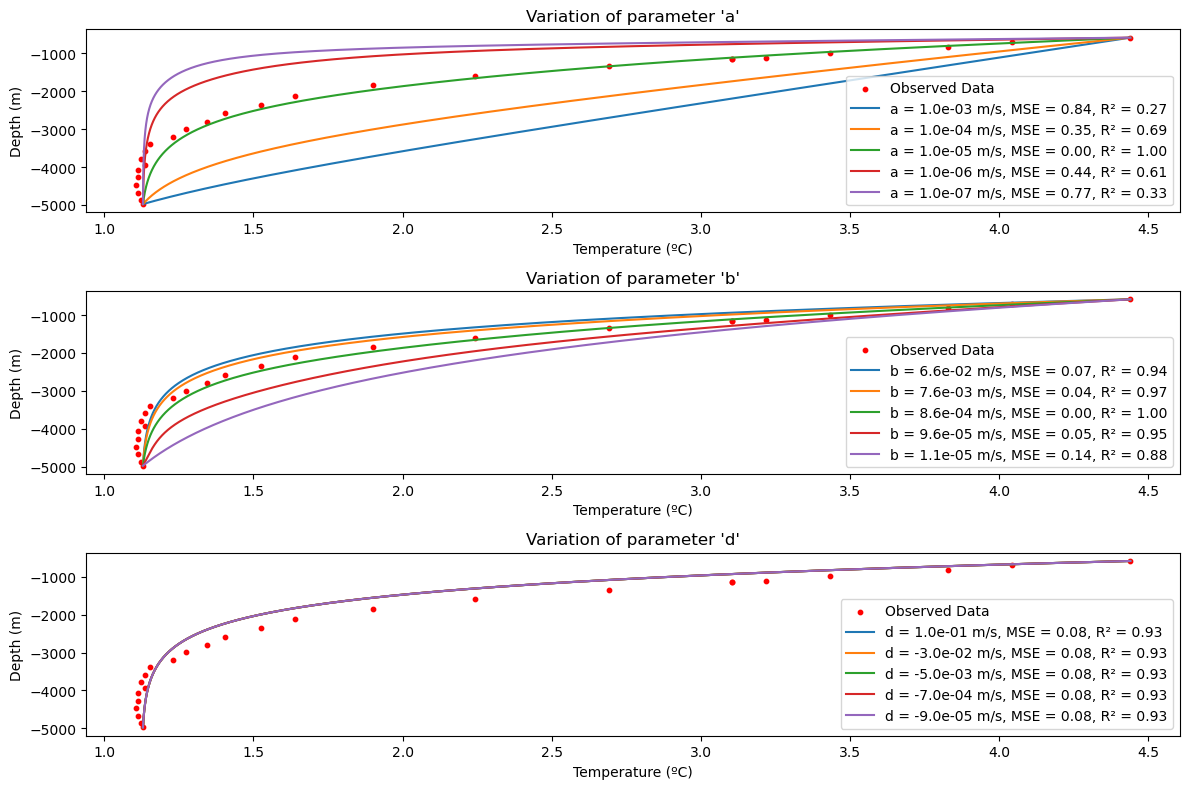

In [14]:
# Now we are going to investigate how the differing profile of kappa influences the temperature profile produced by the model 

a_values = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
b_values = [6.6e-2, 7.6e-3, 8.6e-4, 9.6e-5, 10.6e-6]
d_values = [+1e-1, -3e-2, -5e-3, -7e-4, -9e-5]

w = 6e-9


fig, ax1 = plt.subplots(figsize=(12,8), nrows=3)
fig.subplots_adjust(hspace=0.5)
ax1=ax1.flatten()

for i in range(3):
    ax1[i].scatter(CTD_T, CTD_z, s=10, color='red', label="Observed Data")
    ax1[i].set_xlabel('Temperature (ºC)')
    ax1[i].set_ylabel('Depth (m)') 


for a in a_values:
    # Dedalus code setup and solver
    z_surface = CTD_z[-1]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[-1]
    T_bottom = CTD_T[0]
    Nz = 1000
    
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)
    
    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    kappa['g'] = a + (8.6e-4 - 1e-5) * np.exp((-5e3 - z) / 667)
    
    # Tau variables and problem setup
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)
    
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")
    
    # Solver
    solver = problem.build_solver()
    solver.solve()
    
    # Retrieve the model results
    Tg = T['g']
    
    # Calculate MSE and R²
    mse, r2 = calculate_mse_r2(Tg, z, CTD_T, CTD_z)
    
    r_values.append(r2)
    ms_values.append(mse)
    
    # Plot
    ax1[0].plot(Tg, z, label=f"a = {a:.1e} m/s, MSE = {mse:.2f}, R² = {r2:.2f}")


for b in b_values:
    # Dedalus code setup and solver
    z_surface = CTD_z[-1]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[-1]
    T_bottom = CTD_T[0]
    Nz = 1000
    
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)
    
    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    kappa['g'] = 1e-5 + (b - 1e-5) * np.exp((-5e3 - z) / 667)
    
    # Tau variables and problem setup
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)
    
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")
    
    # Solver
    solver = problem.build_solver()
    solver.solve()
    
    # Retrieve the model results
    Tg = T['g']
    
    # Calculate MSE and R²
    mse, r2 = calculate_mse_r2(Tg, z, CTD_T, CTD_z)
    
    r_values.append(r2)
    ms_values.append(mse)
    
    # Plot
    ax1[1].plot(Tg, z, label=f"b = {b:.1e} m/s, MSE = {mse:.2f}, R² = {r2:.2f}")


for d in d_values:
    # Dedalus code setup and solver
    z_surface = CTD_z[-1]
    z_bottom = CTD_z[0]
    T_surface = CTD_T[-1]
    T_bottom = CTD_T[0]
    Nz = 1000
    
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)
    
    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    kappa['g'] = 1e-5 + (8.6e-4 - 1e-5) * np.exp((d - z) / 667)
    
    # Tau variables and problem setup
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)
    
    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")
    
    # Solver
    solver = problem.build_solver()
    solver.solve()
    
    # Retrieve the model results
    Tg = T['g']
    
    # Calculate MSE and R²
    mse, r2 = calculate_mse_r2(Tg, z, CTD_T, CTD_z)
    
    r_values.append(r2)
    ms_values.append(mse)
    
    # Plot
    ax1[2].plot(Tg, z, label=f"d = {d:.1e} m/s, MSE = {mse:.2f}, R² = {r2:.2f}")


ax1[0].legend()
ax1[1].legend()
ax1[2].legend()

ax1[0].set_title("Variation of parameter 'a'")
ax1[1].set_title("Variation of parameter 'b'")
ax1[2].set_title("Variation of parameter 'd'")


fig.tight_layout()
plt.show()


The three graphs above vary the parameters a, b and d to investigate the stability of the optimal velocity to changes in the profile of $\kappa(z)$. 

Graph 1 reveals that $\kappa(z)$ is hightly sensitive to variation in the linear offset, a. With the fit of the graph varying dramatically with change in this parameter. This is to be expected as the constant a affects the value of the diffusivitiy at all depths so a new optimal vertical velcity, $w$, would need to be found if this constant changed significantly.

Graph 2 reveals that $\kappa(z)$ is moderately sensitive to variation in the exponential prefactor b. This has less of an impact than the factor a, as it adjusts how the diffusivity changes as a function of depth and is not simply a linear offset at all depths of the ocean. 

Graph 3 reveals that the optimal velocity is not sensitive to variation in the paraeter d over the range of values tested with no noticeable change being observed. This is becuase the order of $z$, the depth, is much greater than the order of magnitude of the constant d that is used in these models. If d and $z$ were of the same magnitude and a new optimal $w$ was found, then this new vertical velocity may be more sensitive to variation in the parameter d. 

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as 

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [9]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-3 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2024-12-19 09:55:00,124 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s
2024-12-19 09:55:00,127 __main__ 0/1 INFO :: Starting main loop
2024-12-19 09:55:01,086 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2024-12-19 09:55:01,104 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2024-12-19 09:55:01,121 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2024-12-19 09:55:01,138 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2024-12-19 09:55:01,155 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2024-12-19 09:55:01,179 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2024-12-19 09:55:01,198 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2024-12-19 09:55:01,215 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00
2024-12-19 09:55:01,233 __main__ 0/1 INFO :: Iteratio

## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`

2024-12-19 09:55:02,808 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-19 09:55:02,810 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/d0/r13mw5g137n8_l0hws_ds7bm0000gn/T/tmp2t781hh5/temp.m4v


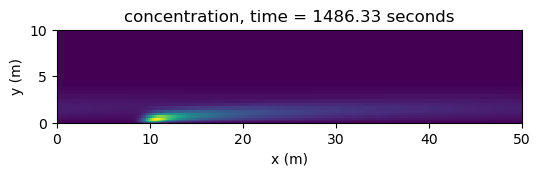

In [10]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).



#### 2.3.0 Scaling analysis and theory considerations 

Permorming a scaling analysis between the 1st and 3rd terms reveals that:

$$T_{diff} \sim \frac{W^2}{\kappa},$$

where $W$ is the width of the river. If we use the values above of $width=10m$ and $\kappa = 1\times 10^{-3}$ then this gives a time scale for diffusion of the pollutant across the river of order 1 day.  

The advective timescale of this problem is given by considering a scaling analysis between the 1st and 2nd terms:

$$T_{adv} \sim  \frac{L_x}{U}.$$

As we are assuming the length of the river to be infinite, this timescale is not relevant for consideration of this problem and we can assume that $Pe <<1$, where $Pe$ is the Peclet number, meaning that the system is dominated by the diffusive timescale. 

If the flow speed of the river is $0.1ms^{-1}$ then the expected downstream distance at which the pollutant reaches the other side of the bank is of the order $1km$.

#### 2.3.1 Looking at temporal concentration profiles for constant positions. 

In [ ]:
# In this code cell we are going to look at plotting the concentrations over time for come consant x cooridnates:



#### 2.3.2 - Pollution concentraitons as functions of time at certain points

The dimensions of our model are 256*32 with 78 time steps

First we are giong to look at how changing kappa affects the concentration 

In [11]:
# Kappa values to test
kappa_values = np.logspace(-1, -3, 10)

# Numerical parameters
Nx = 256  # number of grid points in x
Ny = 32   # number of grid points in y
stop_sim_time = 1500  # end time in seconds
timestep = (L/Nx)/U0  # timestep in seconds, calculated from the CFL number

# Store results for each kappa value
all_c_save = []
all_t_save = []

for kappa in kappa_values:
    # Log the kappa value being tested
    logger.info(f"Running simulation for kappa = {kappa:.3e}")

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)

    # Fields
    c = dist.Field(name='c', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Set the velocity field
    u['g'] = U0 * (1 - (y - w/2)**2.0 / (w/2)**2.0)

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x)**2.0 / S_w**2.0 - (y - S_y)**2.0 / S_w**2.0)

    # Problem setup
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Solver setup
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Save the concentration field over time
    c.change_scales(1)
    c_save = [np.copy(c['g'])]
    t_save = [solver.sim_time]

    # Main loop for each kappa value
    try:
        logger.info(f'Starting main loop for kappa = {kappa:.3e}')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, ending main loop.')
        raise
    finally:
        solver.log_stats()

    # Store results for current kappa
    all_c_save.append(np.array(c_save))
    all_t_save.append(np.array(t_save))

# Now you can plot or analyze the saved concentration fields for each kappa

2024-12-19 09:55:18,247 __main__ 0/1 INFO :: Running simulation for kappa = 1.000e-01
2024-12-19 09:55:18,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s
2024-12-19 09:55:18,563 __main__ 0/1 INFO :: Starting main loop for kappa = 1.000e-01
2024-12-19 09:55:18,590 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00
2024-12-19 09:55:18,607 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00
2024-12-19 09:55:18,624 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00
2024-12-19 09:55:18,642 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00
2024-12-19 09:55:18,659 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00
2024-12-19 09:55:18,676 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00
2024-12-19 09:55:18,693 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00
2024-12-19 09:55:18,710 __main__ 0/1 IN

[0.00000000e+00 2.26957418e-17 7.42681607e-08 1.15417835e-04
 1.90181165e-03 7.24955059e-03 1.49333675e-02 2.26480703e-02
 2.90339594e-02 3.37549561e-02 3.70070553e-02 3.91455590e-02
 4.05076987e-02 4.13559479e-02 4.18755462e-02 4.21899324e-02
 4.23783875e-02 4.24905898e-02 4.25571797e-02 4.25969254e-02
 4.26213759e-02 4.26377682e-02 4.26507592e-02 4.26633913e-02
 4.26775924e-02 4.26944255e-02 4.27142383e-02 4.27367977e-02
 4.27614439e-02 4.27872612e-02 4.28132466e-02 4.28384525e-02
 4.28620890e-02 4.28835801e-02 4.29025782e-02 4.29189463e-02
 4.29327211e-02 4.29440670e-02 4.29532301e-02 4.29604983e-02
 4.29661697e-02 4.29705303e-02 4.29738397e-02 4.29763239e-02
 4.29781728e-02 4.29795418e-02 4.29805546e-02 4.29813072e-02
 4.29818728e-02 4.29823057e-02 4.29826455e-02 4.29829201e-02
 4.29831489e-02 4.29833448e-02 4.29835161e-02 4.29836683e-02
 4.29838044e-02 4.29839263e-02 4.29840351e-02 4.29841318e-02
 4.29842169e-02 4.29842911e-02 4.29843551e-02 4.29844097e-02
 4.29844559e-02 4.298449

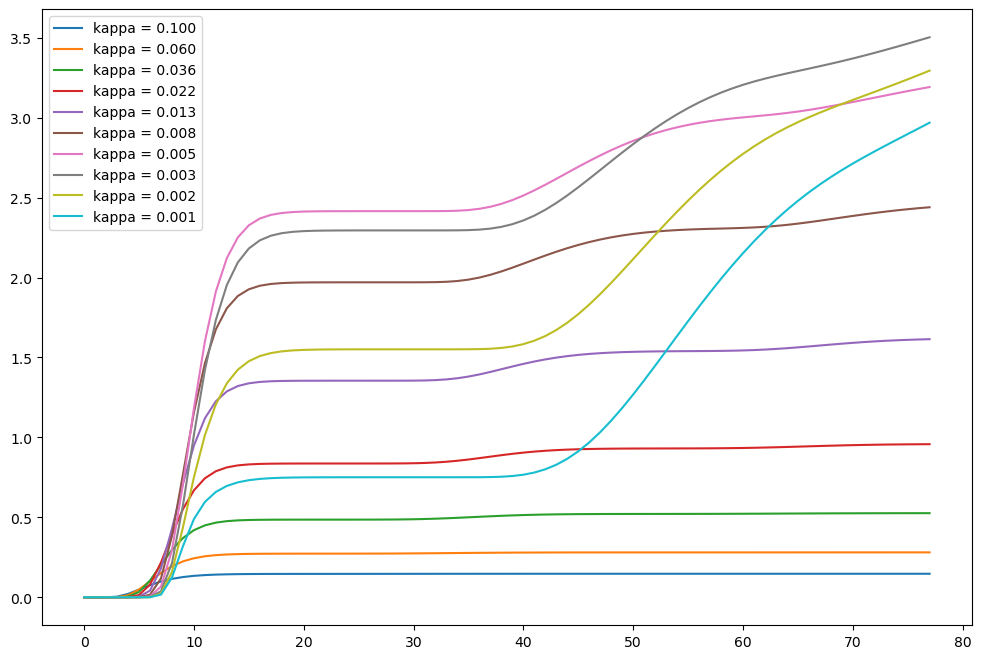

In [12]:
# First let's check the values we have previously calcualted - this is just a little tester to get the code working properly 

print(all_c_save[0][:,100,25])

fig, ax1 = plt.subplots(figsize=(12, 8))

for i in range(10):
    ax1.plot(all_c_save[i][:,100,10], label=f'kappa = {kappa_values[i]:.3f}')

plt.legend()
plt.show()
    

In [13]:
# Now we need to go about altering the river speed and the diffusivity and seeing how this affects the problem 

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.